# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

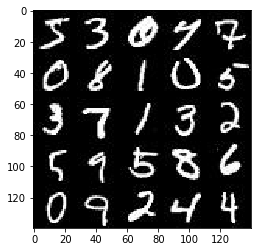

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

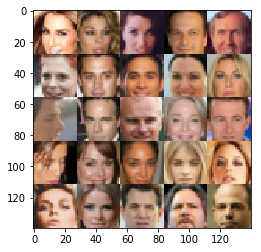

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, (None))
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    def leaky_relu(x):
        return tf.maximum(alpha*x, x)
    
    # Implement Discriminator "Convolution Network"
    with tf.variable_scope('discriminator', reuse=reuse):
       
        # Set up the input  layer 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = leaky_relu(x1)
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        relu2 = leaky_relu(x2)
        # 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same")
        relu3 = leaky_relu(x3)
        
        # Reshape [None, 4096]
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        outputs = tf.sigmoid(logits)
        
        
        return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    def leaky_relu(x):
        return tf.maximum(alpha*x, x)
    
    # Implement Generator "Transpose Convolution Network"
    with tf.variable_scope('generator', reuse=not is_train):
        
        # 7x7x512
        cnv1 = tf.layers.dense(z, 7*7*512)
        cnv1 = tf.reshape(cnv1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(cnv1, training=is_train)
        relu1 = leaky_relu(bn1)
        
        # 7x7x256
        cnv2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding="same")
        bn2 = tf.layers.batch_normalization(cnv2, training=is_train)
        relu2 = leaky_relu(bn2)
        
        # 14x14x128
        cnv3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(cnv3, training=is_train)
        relu3 = leaky_relu(bn3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, beta=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Calculating the Generator and Discriminator Model
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    # Implementing parallel loss functions
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * beta))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    # Calculate the accumulated discriminatory loss
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Seperate out trainable Variables for generator, discriminator Model
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Set up parallel optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    # Return optimizers
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Setup the Variables for Model Training
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    
    # Calculate loss functions
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    # Implement model optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Run optimization
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps=0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimization on batch
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    learn_rate: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z,
                    learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 2.1468... Generator Loss: 1.7683
Epoch 1/2... Batch 20... Discriminator Loss: 1.0266... Generator Loss: 0.9137
Epoch 1/2... Batch 30... Discriminator Loss: 1.7087... Generator Loss: 0.4978
Epoch 1/2... Batch 40... Discriminator Loss: 1.7729... Generator Loss: 0.7048
Epoch 1/2... Batch 50... Discriminator Loss: 1.1903... Generator Loss: 1.0993
Epoch 1/2... Batch 60... Discriminator Loss: 1.4011... Generator Loss: 0.5990
Epoch 1/2... Batch 70... Discriminator Loss: 0.7550... Generator Loss: 1.4415
Epoch 1/2... Batch 80... Discriminator Loss: 1.0848... Generator Loss: 1.3958
Epoch 1/2... Batch 90... Discriminator Loss: 1.1388... Generator Loss: 1.0738
Epoch 1/2... Batch 100... Discriminator Loss: 1.1539... Generator Loss: 1.3186


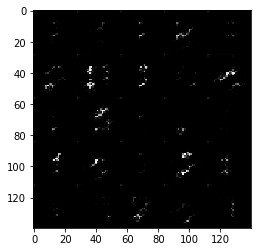

Epoch 1/2... Batch 110... Discriminator Loss: 1.2870... Generator Loss: 0.9462
Epoch 1/2... Batch 120... Discriminator Loss: 1.7354... Generator Loss: 0.3879
Epoch 1/2... Batch 130... Discriminator Loss: 1.2876... Generator Loss: 0.7156
Epoch 1/2... Batch 140... Discriminator Loss: 1.2704... Generator Loss: 0.8847
Epoch 1/2... Batch 150... Discriminator Loss: 1.2575... Generator Loss: 1.1323
Epoch 1/2... Batch 160... Discriminator Loss: 1.2769... Generator Loss: 1.2824
Epoch 1/2... Batch 170... Discriminator Loss: 1.1174... Generator Loss: 1.3422
Epoch 1/2... Batch 180... Discriminator Loss: 1.4248... Generator Loss: 1.1008
Epoch 1/2... Batch 190... Discriminator Loss: 0.9073... Generator Loss: 1.4493
Epoch 1/2... Batch 200... Discriminator Loss: 1.1366... Generator Loss: 0.9470


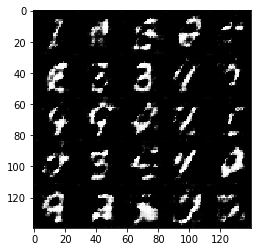

Epoch 1/2... Batch 210... Discriminator Loss: 1.1464... Generator Loss: 0.9489
Epoch 1/2... Batch 220... Discriminator Loss: 1.1947... Generator Loss: 1.2086
Epoch 1/2... Batch 230... Discriminator Loss: 1.3767... Generator Loss: 0.8016
Epoch 1/2... Batch 240... Discriminator Loss: 1.1023... Generator Loss: 1.1696
Epoch 1/2... Batch 250... Discriminator Loss: 1.3251... Generator Loss: 0.8989
Epoch 1/2... Batch 260... Discriminator Loss: 1.1285... Generator Loss: 1.1334
Epoch 1/2... Batch 270... Discriminator Loss: 1.1748... Generator Loss: 1.3106
Epoch 1/2... Batch 280... Discriminator Loss: 1.6377... Generator Loss: 2.0050
Epoch 1/2... Batch 290... Discriminator Loss: 1.1773... Generator Loss: 0.9805
Epoch 1/2... Batch 300... Discriminator Loss: 1.1745... Generator Loss: 1.0452


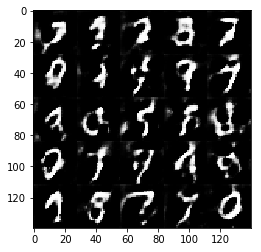

Epoch 1/2... Batch 310... Discriminator Loss: 1.1504... Generator Loss: 1.1596
Epoch 1/2... Batch 320... Discriminator Loss: 1.5463... Generator Loss: 0.7046
Epoch 1/2... Batch 330... Discriminator Loss: 0.9836... Generator Loss: 1.2222
Epoch 1/2... Batch 340... Discriminator Loss: 1.3004... Generator Loss: 1.0051
Epoch 1/2... Batch 350... Discriminator Loss: 1.1215... Generator Loss: 1.0347
Epoch 1/2... Batch 360... Discriminator Loss: 1.0741... Generator Loss: 1.1784
Epoch 1/2... Batch 370... Discriminator Loss: 1.1080... Generator Loss: 1.1381
Epoch 1/2... Batch 380... Discriminator Loss: 1.0879... Generator Loss: 1.1559
Epoch 1/2... Batch 390... Discriminator Loss: 2.1626... Generator Loss: 0.2455
Epoch 1/2... Batch 400... Discriminator Loss: 1.1600... Generator Loss: 1.0629


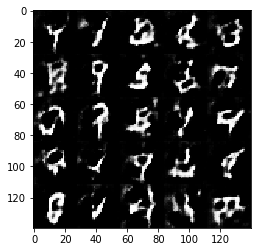

Epoch 1/2... Batch 410... Discriminator Loss: 1.2567... Generator Loss: 0.9600
Epoch 1/2... Batch 420... Discriminator Loss: 1.1266... Generator Loss: 0.8920
Epoch 1/2... Batch 430... Discriminator Loss: 1.1295... Generator Loss: 1.2069
Epoch 1/2... Batch 440... Discriminator Loss: 1.1075... Generator Loss: 1.0318
Epoch 1/2... Batch 450... Discriminator Loss: 1.2424... Generator Loss: 0.9774
Epoch 1/2... Batch 460... Discriminator Loss: 1.2079... Generator Loss: 1.0326
Epoch 2/2... Batch 10... Discriminator Loss: 1.2379... Generator Loss: 1.0072
Epoch 2/2... Batch 20... Discriminator Loss: 1.4894... Generator Loss: 1.5980
Epoch 2/2... Batch 30... Discriminator Loss: 1.1767... Generator Loss: 0.9674
Epoch 2/2... Batch 40... Discriminator Loss: 1.3197... Generator Loss: 0.9070
Epoch 2/2... Batch 50... Discriminator Loss: 1.3170... Generator Loss: 0.8313
Epoch 2/2... Batch 60... Discriminator Loss: 1.3608... Generator Loss: 0.8337
Epoch 2/2... Batch 70... Discriminator Loss: 1.3631... Gen

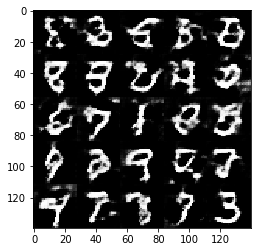

Epoch 2/2... Batch 110... Discriminator Loss: 1.1359... Generator Loss: 1.0769
Epoch 2/2... Batch 120... Discriminator Loss: 1.2965... Generator Loss: 0.9343
Epoch 2/2... Batch 130... Discriminator Loss: 1.4032... Generator Loss: 0.7464
Epoch 2/2... Batch 140... Discriminator Loss: 1.3545... Generator Loss: 0.7135
Epoch 2/2... Batch 150... Discriminator Loss: 1.2392... Generator Loss: 1.0137
Epoch 2/2... Batch 160... Discriminator Loss: 1.4277... Generator Loss: 1.3723
Epoch 2/2... Batch 170... Discriminator Loss: 1.2094... Generator Loss: 1.0937
Epoch 2/2... Batch 180... Discriminator Loss: 1.2279... Generator Loss: 1.0219
Epoch 2/2... Batch 190... Discriminator Loss: 1.2148... Generator Loss: 1.3622
Epoch 2/2... Batch 200... Discriminator Loss: 1.3053... Generator Loss: 0.9218


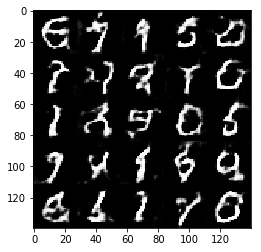

Epoch 2/2... Batch 210... Discriminator Loss: 1.2518... Generator Loss: 0.9773
Epoch 2/2... Batch 220... Discriminator Loss: 1.1567... Generator Loss: 1.1726
Epoch 2/2... Batch 230... Discriminator Loss: 1.2946... Generator Loss: 0.8772
Epoch 2/2... Batch 240... Discriminator Loss: 1.2444... Generator Loss: 0.9527
Epoch 2/2... Batch 250... Discriminator Loss: 1.2417... Generator Loss: 0.8252
Epoch 2/2... Batch 260... Discriminator Loss: 1.2206... Generator Loss: 1.1082
Epoch 2/2... Batch 270... Discriminator Loss: 1.0854... Generator Loss: 1.0857
Epoch 2/2... Batch 280... Discriminator Loss: 1.1725... Generator Loss: 1.0610
Epoch 2/2... Batch 290... Discriminator Loss: 1.2630... Generator Loss: 0.8927
Epoch 2/2... Batch 300... Discriminator Loss: 1.3436... Generator Loss: 0.6967


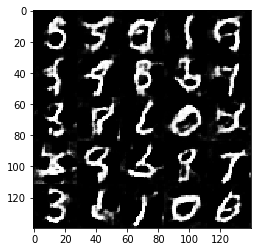

Epoch 2/2... Batch 310... Discriminator Loss: 1.2551... Generator Loss: 1.0056
Epoch 2/2... Batch 320... Discriminator Loss: 1.1703... Generator Loss: 1.0320
Epoch 2/2... Batch 330... Discriminator Loss: 1.3502... Generator Loss: 0.9837
Epoch 2/2... Batch 340... Discriminator Loss: 1.3408... Generator Loss: 0.7546
Epoch 2/2... Batch 350... Discriminator Loss: 1.2796... Generator Loss: 1.1619
Epoch 2/2... Batch 360... Discriminator Loss: 1.3090... Generator Loss: 0.9356
Epoch 2/2... Batch 370... Discriminator Loss: 1.1806... Generator Loss: 1.1897
Epoch 2/2... Batch 380... Discriminator Loss: 1.1954... Generator Loss: 0.9999
Epoch 2/2... Batch 390... Discriminator Loss: 1.5163... Generator Loss: 1.4150
Epoch 2/2... Batch 400... Discriminator Loss: 1.2054... Generator Loss: 0.9600


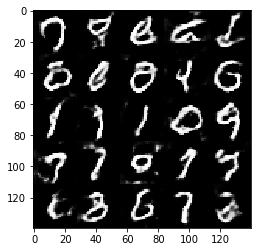

Epoch 2/2... Batch 410... Discriminator Loss: 1.2251... Generator Loss: 1.0012
Epoch 2/2... Batch 420... Discriminator Loss: 1.2258... Generator Loss: 0.6650
Epoch 2/2... Batch 430... Discriminator Loss: 1.4793... Generator Loss: 1.3786
Epoch 2/2... Batch 440... Discriminator Loss: 1.1458... Generator Loss: 1.0033
Epoch 2/2... Batch 450... Discriminator Loss: 1.1656... Generator Loss: 0.9031
Epoch 2/2... Batch 460... Discriminator Loss: 1.1312... Generator Loss: 1.0611


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5

print_every = 50 
show_every = 250

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 100... Discriminator Loss: 1.2051... Generator Loss: 0.9720
Epoch 1/1... Batch 200... Discriminator Loss: 1.4059... Generator Loss: 0.8729
Epoch 1/1... Batch 300... Discriminator Loss: 1.2890... Generator Loss: 0.8736
Epoch 1/1... Batch 400... Discriminator Loss: 1.3340... Generator Loss: 0.8569
Epoch 1/1... Batch 500... Discriminator Loss: 1.4419... Generator Loss: 0.7714
Epoch 1/1... Batch 600... Discriminator Loss: 1.3416... Generator Loss: 0.8602
Epoch 1/1... Batch 700... Discriminator Loss: 1.3691... Generator Loss: 0.7944


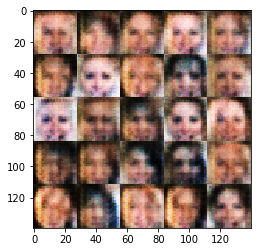

Epoch 1/1... Batch 800... Discriminator Loss: 1.3898... Generator Loss: 0.7971
Epoch 1/1... Batch 900... Discriminator Loss: 1.4133... Generator Loss: 0.7847
Epoch 1/1... Batch 1000... Discriminator Loss: 1.3572... Generator Loss: 0.8034
Epoch 1/1... Batch 1100... Discriminator Loss: 1.4215... Generator Loss: 0.7813
Epoch 1/1... Batch 1200... Discriminator Loss: 1.4168... Generator Loss: 0.7740
Epoch 1/1... Batch 1300... Discriminator Loss: 1.4035... Generator Loss: 0.7846
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3921... Generator Loss: 0.8085
Epoch 1/1... Batch 1500... Discriminator Loss: 1.3850... Generator Loss: 0.7882


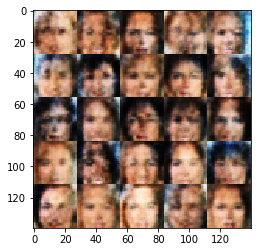

Epoch 1/1... Batch 1600... Discriminator Loss: 1.3757... Generator Loss: 0.8116
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3892... Generator Loss: 0.7899
Epoch 1/1... Batch 1800... Discriminator Loss: 1.4059... Generator Loss: 0.7914
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3663... Generator Loss: 0.8075
Epoch 1/1... Batch 2000... Discriminator Loss: 1.4015... Generator Loss: 0.7788
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3741... Generator Loss: 0.7850
Epoch 1/1... Batch 2200... Discriminator Loss: 1.3825... Generator Loss: 0.7946


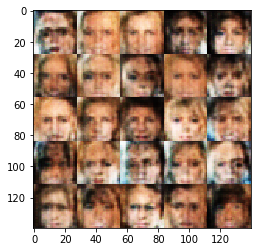

Epoch 1/1... Batch 2300... Discriminator Loss: 1.3685... Generator Loss: 0.8070
Epoch 1/1... Batch 2400... Discriminator Loss: 1.3699... Generator Loss: 0.8014
Epoch 1/1... Batch 2500... Discriminator Loss: 1.3607... Generator Loss: 0.8295
Epoch 1/1... Batch 2600... Discriminator Loss: 1.3743... Generator Loss: 0.7576
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3842... Generator Loss: 0.7756
Epoch 1/1... Batch 2800... Discriminator Loss: 1.3941... Generator Loss: 0.7680
Epoch 1/1... Batch 2900... Discriminator Loss: 1.3710... Generator Loss: 0.8044
Epoch 1/1... Batch 3000... Discriminator Loss: 1.3830... Generator Loss: 0.8074


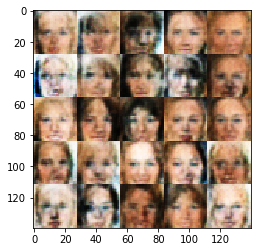

Epoch 1/1... Batch 3100... Discriminator Loss: 1.3843... Generator Loss: 0.8202


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

print_every = 100 
show_every = 750

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,print_every=print_every, show_every=show_every)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.